In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report
import pickle
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

In [2]:
# reading in datafrane
df = pd.read_csv('qb_final1.csv')
df = df.drop(columns=['Unnamed: 0', '3 Cone', 'Shuttle', 'Vertical Jump', 'Position', 'PK', 'PK1', 'Year_x', 'Year_y', 'Last_Year', 'year_drafted', 'AdjustedYds'])

In [3]:
# checking column list
for x in df.columns:
    print(x)

Round
Pick
Team
Player
Age
School
Weight
40 Time
Height (in)
G
Completions
Attempts
CompletionPCT
PassYds
YardsPerAttempt
AdjustedYardsPerAttempt
PassingTDs
Int
EfficiencyRtg
RushAtt
RushYds
RushAvg
RushTD
YPG
Conf
response


In [4]:
# removing rows that are na in the most important columns, since these will not be accurate
df = df[(df['response'].notna()) & (df['PassYds'].notna())]
df.isna().sum()

Round                       0
Pick                        0
Team                        0
Player                      0
Age                        19
School                      0
Weight                     24
40 Time                    49
Height (in)                24
G                           0
Completions                 0
Attempts                    0
CompletionPCT               0
PassYds                     0
YardsPerAttempt             0
AdjustedYardsPerAttempt     0
PassingTDs                  0
Int                         0
EfficiencyRtg               0
RushAtt                     0
RushYds                     0
RushAvg                     0
RushTD                      0
YPG                         0
Conf                        0
response                    0
dtype: int64

In [5]:
df.shape

(276, 26)

In [6]:
# setting missing values to median in less critical columns
df = df.copy()
# df.loc[df['RushAvg'].isna(), 'RushAvg'] = 0
df.loc[df['Weight'].isna(), 'Weight'] = df['Weight'].median()
df.loc[df['40 Time'].isna(), '40 Time'] = df['40 Time'].median()
df.loc[df['Height (in)'].isna(), 'Height (in)'] = df['Height (in)'].median()
df.loc[df['Age'].isna(), 'Age'] = df['Age'].median()

In [7]:
# removing outliers
df = df[(np.abs(stats.zscore(df['Attempts'])) < 3)]
df = df[(np.abs(stats.zscore(df['RushYds'])) < 3)]
df = df[(np.abs(stats.zscore(df['PassYds'])) < 3)]
df = df[(np.abs(stats.zscore(df['RushAtt'])) < 3)]
df = df[(np.abs(stats.zscore(df['YPG'])) < 3)]
df = df[(np.abs(stats.zscore(df['RushAtt'])) < 3)]
df = df[(np.abs(stats.zscore(df['RushTD'])) < 3)]
df = df[(np.abs(stats.zscore(df['AdjustedYardsPerAttempt'])) < 3)]
df = df[(np.abs(stats.zscore(df['YardsPerAttempt'])) < 3)]
df = df[(np.abs(stats.zscore(df['Int'])) < 3)]
df.shape

(257, 26)

In [8]:
# seperating features and response
df = df.reset_index(drop=True)
response = df['response']
df_features = df.drop(columns = ['Player', 'response'])

In [9]:
# seperating data into numeric and categorical columns
df_cat = df[['Team', 'School', 'Conf']].copy()
df_num = df.drop(columns = ['Team', 'School', 'Conf', 'Player', 'response']).copy()

In [10]:
# checking for high correlations with response variable
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df.corr())

                            Round      Pick       Age    Weight   40 Time  \
Round                    1.000000  0.989506  0.323656 -0.272132  0.145343   
Pick                     0.989506  1.000000  0.313706 -0.266744  0.140259   
Age                      0.323656  0.313706  1.000000 -0.133735  0.186115   
Weight                  -0.272132 -0.266744 -0.133735  1.000000  0.125295   
40 Time                  0.145343  0.140259  0.186115  0.125295  1.000000   
Height (in)             -0.189366 -0.192415 -0.081051  0.589464  0.267964   
G                       -0.109194 -0.102921  0.015079  0.003678  0.010439   
Completions             -0.136876 -0.134508  0.040266  0.016627  0.123838   
Attempts                -0.118536 -0.116714  0.031538  0.035471  0.126876   
CompletionPCT           -0.114721 -0.110114  0.036026 -0.028341  0.039639   
PassYds                 -0.157387 -0.158274  0.028139  0.011681  0.100500   
YardsPerAttempt         -0.153798 -0.165068 -0.032969 -0.060083 -0.143514   

(array([ 26.,  24.,  99., 108.]),
 array([1.  , 1.75, 2.5 , 3.25, 4.  ]),
 <BarContainer object of 4 artists>)

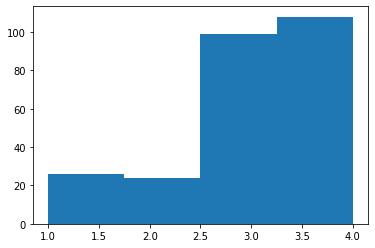

In [11]:
# checking distribution
plt.hist(df['response'], bins=4)

(array([ 2., 30.,  1., 55., 43., 16., 54., 27., 16., 13.]),
 array([ 5. ,  9.8, 14.6, 19.4, 24.2, 29. , 33.8, 38.6, 43.4, 48.2, 53. ]),
 <BarContainer object of 10 artists>)

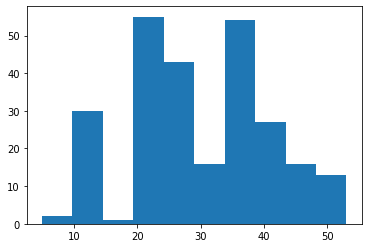

In [12]:
plt.hist(df['G'], bins=10)

(array([20., 30., 45., 38., 37., 39., 21., 16.,  6.,  5.]),
 array([ 116. ,  229.1,  342.2,  455.3,  568.4,  681.5,  794.6,  907.7,
        1020.8, 1133.9, 1247. ]),
 <BarContainer object of 10 artists>)

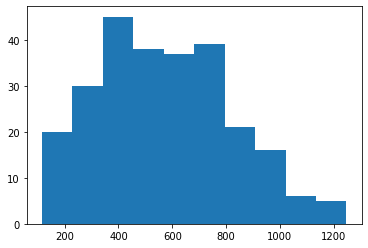

In [13]:
# this cell was run on all columns originally
plt.hist(df['Completions'], bins=10)

In [14]:
# creating training and testing data for catboost model
X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(df_features, response, test_size=.2)

In [15]:
# initiating model
cat_model = CatBoostClassifier()

# using grid search to determine best parameters
grid = {'iterations': [1, 2, 3, 4, 5],
        'depth': [1, 2, 4, 6, 10],
        'learning_rate': [.3, .7, 1]}

# Pooling data before fitting
pool_train = Pool(X_train_cb, y_train_cb, cat_features=['Team', 'School', 'Conf'])
# running a grid search to determine parameters
gs_result = cat_model.grid_search(grid, pool_train)

0:	learn: 1.1863403	test: 1.2344260	best: 1.2344260 (0)	total: 157ms	remaining: 0us

bestTest = 1.234426016
bestIteration = 0

0:	loss: 1.2344260	best: 1.2344260 (0)	total: 192ms	remaining: 14.2s
0:	learn: 1.0327952	test: 1.1465398	best: 1.1465398 (0)	total: 609us	remaining: 0us

bestTest = 1.146539771
bestIteration = 0

1:	loss: 1.1465398	best: 1.1465398 (1)	total: 194ms	remaining: 7.08s
0:	learn: 1.0012913	test: 1.1653031	best: 1.1653031 (0)	total: 547us	remaining: 0us

bestTest = 1.165303103
bestIteration = 0

2:	loss: 1.1653031	best: 1.1465398 (1)	total: 196ms	remaining: 4.69s
0:	learn: 1.1863403	test: 1.2344260	best: 1.2344260 (0)	total: 628us	remaining: 628us
1:	learn: 1.1329447	test: 1.2030506	best: 1.2030506 (1)	total: 1.16ms	remaining: 0us

bestTest = 1.203050623
bestIteration = 1

3:	loss: 1.2030506	best: 1.1465398 (1)	total: 198ms	remaining: 3.52s
0:	learn: 1.0327952	test: 1.1465398	best: 1.1465398 (0)	total: 751us	remaining: 751us
1:	learn: 1.0019504	test: 1.1486132	best: 1

In [16]:
# pooling test data
pool_test = Pool(X_test_cb, y_test_cb, cat_features=['Team', 'School', 'Conf'])

# making predictions
cat_preds = cat_model.predict(pool_test)
cat_proba = cat_model.predict_proba(pool_test)

In [17]:
# display(f1_score(y_test_cb, cat_preds, average='macro'))
print(classification_report(y_test_cb, cat_preds))

              precision    recall  f1-score   support

         1.0       0.40      0.40      0.40         5
         2.0       0.00      0.00      0.00         3
         3.0       0.60      0.55      0.57        22
         4.0       0.77      0.91      0.83        22

    accuracy                           0.65        52
   macro avg       0.44      0.46      0.45        52
weighted avg       0.62      0.65      0.63        52



In [18]:
confusion_matrix(y_test_cb, cat_preds)

array([[ 2,  0,  3,  0],
       [ 0,  0,  3,  0],
       [ 3,  1, 12,  6],
       [ 0,  0,  2, 20]], dtype=int64)

In [19]:
# creating a deep learning model to improve score
df_cat.head()

,Team,School,Conf
0,WAS,Tennessee,SEC
1,TAM,Fresno St.,WAC
2,PIT,Michigan St.,Big Ten
3,WAS,Tulsa,Ind
4,KAN,Memphis,Ind


In [20]:
df_num.head()

,Round,Pick,Age,Weight,40 Time,Height (in),G,Completions,Attempts,CompletionPCT,...,YardsPerAttempt,AdjustedYardsPerAttempt,PassingTDs,Int,EfficiencyRtg,RushAtt,RushYds,RushAvg,RushTD,YPG
0,1,3,22.0,221.0,4.82,74.0,11.0,184.0,285.0,64.6,...,8.259649,8.8,25.0,8.0,157.3,46.0,73.0,1.6,3.0,214.000000
1,1,6,22.0,228.0,4.82,75.3,12.0,254.0,396.0,64.1,...,9.593434,10.5,30.0,5.0,167.2,40.0,-113.0,-2.8,1.0,316.583333
2,6,178,23.0,227.0,5.13,74.3,12.0,215.0,336.0,64.0,...,6.752976,5.8,9.0,11.0,123.0,41.0,-160.0,-3.9,0.0,189.083333
3,7,197,23.0,221.0,5.04,75.0,11.0,214.0,383.0,55.9,...,7.496084,6.8,21.0,15.0,129.1,73.0,10.0,0.1,1.0,261.000000
4,7,199,23.0,208.0,4.82,74.9,9.0,166.0,273.0,60.8,...,6.945055,5.8,13.0,13.0,125.3,38.0,-176.0,-4.6,1.0,210.666667


In [21]:
# scaling numeric data
scaler = StandardScaler()

scaled_data = pd.DataFrame(scaler.fit_transform(df_num), columns = df_num.columns)

In [22]:
scaled_data

,Round,Pick,Age,Weight,40 Time,Height (in),G,Completions,Attempts,CompletionPCT,...,YardsPerAttempt,AdjustedYardsPerAttempt,PassingTDs,Int,EfficiencyRtg,RushAtt,RushYds,RushAvg,RushTD,YPG
0,-1.316667,-1.387645,-0.832815,-0.144257,-0.031180,-0.686386,-1.782153,-1.585677,-1.696893,-1.636305,...,0.455390,0.739926,-1.207959,-1.413694,-1.589380,-1.240042,-0.407914,-0.057434,-0.752009,-0.597331
1,-1.316667,-1.350505,-0.832815,0.490262,-0.031180,0.131743,-1.688662,-1.300034,-1.405877,-1.645713,...,2.075590,2.142279,-1.006030,-1.677415,-1.507561,-1.291921,-0.701872,-0.736074,-1.020062,1.554892
2,0.963545,0.778819,0.181562,0.399616,1.894498,-0.497587,-1.688662,-1.459178,-1.563183,-1.647595,...,-1.374823,-1.734814,-1.854132,-1.149973,-1.872854,-1.283274,-0.776152,-0.905735,-1.154089,-1.120088
3,1.419587,1.014035,0.181562,-0.144257,1.335430,-0.057056,-1.782153,-1.463259,-1.439960,-1.800001,...,-0.472143,-0.909901,-1.369502,-0.798346,-1.822441,-1.006588,-0.507480,-0.288788,-1.020062,0.388741
4,1.419587,1.038795,0.181562,-1.322649,-0.031180,-0.119989,-1.969136,-1.659129,-1.728354,-1.707805,...,-1.141498,-1.734814,-1.692589,-0.974159,-1.853846,-1.309214,-0.801438,-1.013700,-1.020062,-0.667265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,-0.860625,-0.632477,0.181562,1.215426,1.708142,1.201604,-0.566768,-0.141139,-0.370281,-0.296635,...,1.515971,1.696972,0.528629,-0.798346,-0.111678,-0.539680,-0.431620,-0.165399,-0.215903,1.227950
253,-0.404582,-0.607718,-0.832815,0.037034,-0.031180,-0.057056,1.490039,0.932064,1.116259,1.545412,...,-0.936106,-0.516336,0.649787,0.256538,1.423050,2.149366,2.019609,2.009336,1.794496,-0.680795
254,-0.404582,-0.595338,-0.832815,-0.506839,-0.031180,-0.057056,-2.343100,-1.810111,-1.932851,-1.606200,...,-0.183946,-0.084987,-1.934903,-1.853229,-1.733183,-1.378385,-0.464809,-0.119128,-0.752009,1.240538
255,0.051460,0.221728,0.181562,-1.050712,-1.087197,-1.945046,0.461636,0.446470,0.350704,0.779617,...,0.098961,0.547627,0.528629,-0.710439,0.808167,1.155024,1.548644,1.546626,1.124363,0.003304


In [23]:
# one hot encoding categorigcal variables
ohe = OneHotEncoder(sparse=False)

encoded_data = pd.DataFrame(ohe.fit_transform(df_cat))
encoded_data.columns = ohe.get_feature_names_out()

encoded_data

,Team_ARI,Team_ATL,Team_BAL,Team_BUF,Team_CAR,Team_CHI,Team_CIN,Team_CLE,Team_DAL,Team_DEN,...,Conf_Big West,Conf_CUSA,Conf_Ind,Conf_MAC,Conf_MWC,Conf_Pac-10,Conf_Pac-12,Conf_SEC,Conf_Sun Belt,Conf_WAC
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
# combining the dataframes
working_df = scaled_data.merge(encoded_data, left_index=True, right_index=True)
working_df['response'] = response
working_df.head()

,Round,Pick,Age,Weight,40 Time,Height (in),G,Completions,Attempts,CompletionPCT,...,Conf_CUSA,Conf_Ind,Conf_MAC,Conf_MWC,Conf_Pac-10,Conf_Pac-12,Conf_SEC,Conf_Sun Belt,Conf_WAC,response
0,-1.316667,-1.387645,-0.832815,-0.144257,-0.031180,-0.686386,-1.782153,-1.585677,-1.696893,-1.636305,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0
1,-1.316667,-1.350505,-0.832815,0.490262,-0.031180,0.131743,-1.688662,-1.300034,-1.405877,-1.645713,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
2,0.963545,0.778819,0.181562,0.399616,1.894498,-0.497587,-1.688662,-1.459178,-1.563183,-1.647595,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
3,1.419587,1.014035,0.181562,-0.144257,1.335430,-0.057056,-1.782153,-1.463259,-1.439960,-1.800001,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
4,1.419587,1.038795,0.181562,-1.322649,-0.031180,-0.119989,-1.969136,-1.659129,-1.728354,-1.707805,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [25]:
# creating training and testing data for remaining models
X_train, X_test, y_train, y_test = train_test_split(working_df.drop(columns='response'),working_df['response'], test_size=.2)

In [26]:
# compiling sequential model, with relu as activation function and softmax as output layer
model = keras.models.Sequential([
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(1, activation='softmax')
])

In [27]:
# compiling the model
model.compile(loss="categorical_crossentropy",
              optimizer='adam',
              metrics=['accuracy'])

In [28]:
# fitting the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test,y_test))

Epoch 1/20
7/7 [==============================] - 1s 29ms/step - loss: 0.0000e+00 - accuracy: 0.1073 - val_loss: 0.0000e+00 - val_accuracy: 0.0769
Epoch 2/20
7/7 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 0.1073 - val_loss: 0.0000e+00 - val_accuracy: 0.0769
Epoch 3/20
7/7 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 0.1073 - val_loss: 0.0000e+00 - val_accuracy: 0.0769
Epoch 4/20
7/7 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 0.1073 - val_loss: 0.0000e+00 - val_accuracy: 0.0769
Epoch 5/20
7/7 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 0.1073 - val_loss: 0.0000e+00 - val_accuracy: 0.0769
Epoch 6/20
7/7 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 0.1073 - val_loss: 0.0000e+00 - val_accuracy: 0.0769
Epoch 7/20
7/7 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 0.1073 - val_loss: 0.0000e+00 

In [29]:
# using pca to reduce dimensions
pca = PCA()

# reducing dimensionality while keeping 90% variance
pca = PCA(n_components=0.95)

# fitting and transforming the data
X_reduced = pd.DataFrame(pca.fit_transform(working_df.drop(columns='response')), columns=['pca_comp_%i' % i for i in range(39)])

X_reduced

,pca_comp_0,pca_comp_1,pca_comp_2,pca_comp_3,pca_comp_4,pca_comp_5,pca_comp_6,pca_comp_7,pca_comp_8,pca_comp_9,...,pca_comp_29,pca_comp_30,pca_comp_31,pca_comp_32,pca_comp_33,pca_comp_34,pca_comp_35,pca_comp_36,pca_comp_37,pca_comp_38
0,-4.544895,-0.977905,1.874827,-0.637310,-1.490751,-0.486049,-0.041333,0.546840,0.429470,-0.185820,...,0.256899,-0.168792,-0.154578,-0.134651,-0.106037,0.067100,-0.246963,0.033826,0.102572,0.241463
1,-4.103712,-0.267222,4.270426,0.578306,-0.263666,0.323026,0.018934,0.037947,0.198868,0.520665,...,0.464112,0.463209,-0.052250,-0.122312,-0.286476,-0.239502,0.046862,-0.223994,-0.506327,0.252978
2,-5.155768,1.739608,-2.016996,-0.927545,-0.194698,0.063367,0.170626,1.438809,0.706235,-0.525907,...,-0.232675,0.548283,0.198857,0.159088,0.106818,0.368538,0.278345,-0.334406,-0.054928,-0.056559
3,-4.632267,1.193098,-1.157548,0.345012,0.308780,1.215938,0.363852,0.925609,0.231171,-0.120042,...,0.040806,-0.259651,0.213716,-0.123893,0.007689,-0.004977,-0.007147,0.055553,-0.150895,-0.148720
4,-5.314204,1.100816,-2.315533,0.028236,-1.055464,0.727827,0.077332,-0.199024,-0.510160,0.292038,...,-0.203815,-0.089247,0.508171,0.386664,0.073026,-0.193674,0.274144,-0.306331,0.107988,-0.210368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,-0.655878,0.796030,3.236848,0.351007,1.608051,-0.233360,0.352184,1.218981,-0.006387,-0.168502,...,0.050826,-0.062773,-0.385606,0.043151,-0.390329,0.025688,0.226566,0.043678,-0.166239,0.194128
253,3.946892,-2.738569,-1.125164,-1.430334,0.275748,0.062216,-0.260640,0.999664,-0.252428,-0.847270,...,-0.090796,-0.034266,-0.025148,-0.056369,-0.014489,-0.165137,-0.110195,-0.224423,0.085161,0.107766
254,-5.345066,-0.294960,1.225778,-0.400822,-1.087206,1.405412,0.340904,0.300319,-0.352459,-0.200551,...,-0.010451,0.041288,0.094207,0.064713,-0.146047,-0.318180,-0.199158,0.010333,0.138370,0.057904
255,1.802894,-2.962190,-0.741076,1.485159,-0.635017,0.086714,0.250346,-0.042538,0.138210,-0.843826,...,-0.134340,-0.018855,-0.087045,-0.126435,-0.044435,-0.012229,-0.008139,0.074265,-0.150620,-0.031288


In [30]:
# splitting pca reduced data
X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(X_reduced, working_df['response'], test_size=.2)

In [31]:
# compiling sequential model, with relu as activation function and softmax as output layer
model1 = keras.models.Sequential([
    keras.layers.Dense(200, input_dim=39, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(1, activation='softmax')
])

In [32]:
# trying a deep learning model with reduced data
model1.compile(loss="categorical_crossentropy",
              optimizer='adam',
              metrics=['accuracy'])

In [33]:
history = model1.fit(X_train_reduced, y_train, epochs=20, validation_data=(X_test_reduced,y_test))

Epoch 1/20
7/7 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 0.1073 - val_loss: 0.0000e+00 - val_accuracy: 0.0769
Epoch 2/20
7/7 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 0.1073 - val_loss: 0.0000e+00 - val_accuracy: 0.0769
Epoch 3/20
7/7 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 0.1073 - val_loss: 0.0000e+00 - val_accuracy: 0.0769
Epoch 4/20
7/7 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 0.1073 - val_loss: 0.0000e+00 - val_accuracy: 0.0769
Epoch 5/20
7/7 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 0.1073 - val_loss: 0.0000e+00 - val_accuracy: 0.0769
Epoch 6/20
7/7 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 0.1073 - val_loss: 0.0000e+00 - val_accuracy: 0.0769
Epoch 7/20
7/7 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 0.1073 - val_loss: 0.0000e+00 

In [34]:
# creating a non scaled, encoded df
ns_data = df_num.merge(encoded_data, left_index=True, right_index=True)

# creating training and testing data 
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(ns_data,working_df['response'], test_size=.2)

In [35]:
# creating another reduced dataset for non scaled numeric values
reduced_ns = pd.DataFrame(pca.fit_transform(ns_data))

# creating training and testing data 
X_train_reduced_ns, X_test_reduced_ns, y_train_ns, y_test_ns = train_test_split(reduced_ns ,working_df['response'], test_size=.2)

In [36]:
# testing a random forest classifier
rfc = RandomForestClassifier()

# fitting the data
rfc.fit(X_train_ns, y_train_ns)

# predicting
rfc_preds = rfc.predict(X_test_ns)

# checking model 
print(classification_report(y_test_ns, rfc_preds))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         4
         2.0       0.00      0.00      0.00         4
         3.0       0.52      0.57      0.54        23
         4.0       0.38      0.48      0.43        21

    accuracy                           0.44        52
   macro avg       0.23      0.26      0.24        52
weighted avg       0.39      0.44      0.41        52



C:\Users\billy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\billy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\billy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
# testing a gradient boosting classifier
gbc = GradientBoostingClassifier()

# fitting the data
gbc.fit(X_train_ns, y_train_ns)

# predicting
gbc_preds = gbc.predict(X_test_ns)

# checking model 
print(classification_report(y_test_ns, gbc_preds))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         4
         2.0       0.00      0.00      0.00         4
         3.0       0.52      0.48      0.50        23
         4.0       0.31      0.38      0.34        21

    accuracy                           0.37        52
   macro avg       0.21      0.21      0.21        52
weighted avg       0.36      0.37      0.36        52



In [38]:
# testing a gaussian naive bayes classifier
gc = GaussianNB()

# fitting the data
gc.fit(X_train_ns, y_train_ns)

# predicting
gc_preds = gc.predict(X_test_ns)

# checking model 
print(classification_report(y_test_ns, gc_preds))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         4
         2.0       0.00      0.00      0.00         4
         3.0       0.38      0.39      0.38        23
         4.0       0.43      0.29      0.34        21

    accuracy                           0.29        52
   macro avg       0.20      0.17      0.18        52
weighted avg       0.34      0.29      0.31        52



In [39]:
# testing a KNN classifier
knn = KNeighborsClassifier(n_neighbors=3)

# fitting the data
knn.fit(X_train, y_train)

# predicting
knn_preds = knn.predict(X_test)

# checking model 
print(classification_report(y_test, knn_preds))

              precision    recall  f1-score   support

         1.0       0.17      0.25      0.20         4
         2.0       0.10      0.33      0.15         3
         3.0       0.33      0.24      0.28        21
         4.0       0.33      0.29      0.31        24

    accuracy                           0.27        52
   macro avg       0.23      0.28      0.24        52
weighted avg       0.31      0.27      0.28        52



In [40]:
# testing a KNN classifier with PCA reduced data
knn1 = KNeighborsClassifier(n_neighbors=3)

# fitting the data
knn1.fit(X_train_reduced, y_train)

# predicting
knn_preds1 = knn1.predict(X_test_reduced)

# checking model 
print(classification_report(y_test, knn_preds1))

              precision    recall  f1-score   support

         1.0       0.25      0.25      0.25         4
         2.0       0.10      0.33      0.15         3
         3.0       0.45      0.24      0.31        21
         4.0       0.67      0.75      0.71        24

    accuracy                           0.48        52
   macro avg       0.37      0.39      0.36        52
weighted avg       0.52      0.48      0.48        52



In [41]:
# testing a random forest classifier on the reduced dataset
rfc = RandomForestClassifier()

# fitting the data
rfc.fit(X_train_reduced_ns, y_train_ns)

# predicting
rfc_preds = rfc.predict(X_test_reduced_ns)

# checking model 
print(classification_report(y_test_ns, rfc_preds))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         4
         2.0       0.20      0.50      0.29         4
         3.0       0.53      0.43      0.48        23
         4.0       0.50      0.43      0.46        21

    accuracy                           0.40        52
   macro avg       0.31      0.34      0.31        52
weighted avg       0.45      0.40      0.42        52



In [42]:
# testing a gradient boosting classifier on the reduced data
gbcr = GradientBoostingClassifier()

# fitting the data
gbcr.fit(X_train_reduced_ns, y_train_ns)

# predicting
gbc_predsr = gbcr.predict(X_test_reduced_ns)

# checking model 
print(classification_report(y_test_ns, gbc_predsr))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         4
         2.0       0.20      0.50      0.29         4
         3.0       0.50      0.39      0.44        23
         4.0       0.47      0.43      0.45        21

    accuracy                           0.38        52
   macro avg       0.29      0.33      0.29        52
weighted avg       0.43      0.38      0.40        52



In [43]:
# performing grid searches on the random forrest and gradient boosting classifier
rfparams = {
    'max_depth': [1,2,3,4,5,8,16,32],
    'max_leaf_nodes': list(range(2, 20, 1)),
    'min_samples_split': [2,3,4,5,8,12,16,20]
}

# initializing gridsearch
grid_search_rf = GridSearchCV(RandomForestClassifier(), rfparams, verbose=1, cv=3, n_jobs=-1)

grid_search_rf.fit(X_train_ns, y_train_ns)

# getting best params
print("Best parameters are: ", grid_search_rf.best_params_)

Fitting 3 folds for each of 1152 candidates, totalling 3456 fits
Best parameters are:  {'max_depth': 2, 'max_leaf_nodes': 16, 'min_samples_split': 2}


In [44]:
# performing another gridsearch for the random forest model
rfparams = {
    'max_depth': [12, 14, 16, 18, 20, 22, 24],
    'max_leaf_nodes': [8],
    'min_samples_split': [2,3]
}

# initializing gridsearch
grid_search_rf = GridSearchCV(RandomForestClassifier(), rfparams, verbose=1, cv=3, n_jobs=-1)

grid_search_rf.fit(X_train_ns, y_train_ns)

# getting best params
print("Best parameters are: ", grid_search_rf.best_params_)

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Best parameters are:  {'max_depth': 14, 'max_leaf_nodes': 8, 'min_samples_split': 2}


In [45]:
# performing a final gridsearch for the random forest model
rfparams = {
    'max_depth': [10, 11, 12, 13],
    'max_leaf_nodes': [8],
    'min_samples_split': [2]
}

# initializing gridsearch
grid_search_rf = GridSearchCV(RandomForestClassifier(), rfparams, verbose=1, cv=3, n_jobs=-1)

grid_search_rf.fit(X_train_ns, y_train_ns)

# getting best params
print("Best parameters are: ", grid_search_rf.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters are:  {'max_depth': 10, 'max_leaf_nodes': 8, 'min_samples_split': 2}


In [46]:
# testing a random forest classifier with best parameters
rfcbp = RandomForestClassifier(max_depth=12, max_leaf_nodes=8, min_samples_split=2)

# fitting the data
rfcbp.fit(X_train_ns, y_train_ns)

# predicting
rfc_preds = rfcbp.predict(X_test_ns)

# checking model 
print(classification_report(y_test_ns, rfc_preds))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         4
         2.0       0.00      0.00      0.00         4
         3.0       0.55      0.52      0.53        23
         4.0       0.43      0.62      0.51        21

    accuracy                           0.48        52
   macro avg       0.24      0.29      0.26        52
weighted avg       0.42      0.48      0.44        52



C:\Users\billy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\billy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\billy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
# performing grid searches on the gradient boosting classifier DO NOT RERUN THIS CELL
gbparams = {
    'learning_rate': [0, .1, .5, 1],
    'max_depth': [1,2,3,4,5,8,16,32],
    'max_leaf_nodes': list(range(2, 20, 1)),
    'min_samples_split': [2,3,4,5,8,12,16,20]
}

# initializing gridsearch
grid_search_gc = GridSearchCV(GradientBoostingClassifier(), gbparams, verbose=1, cv=3, n_jobs=-1)

grid_search_gc.fit(X_train_ns, y_train_ns)

# getting best params
print("Best parameters are: ", grid_search_gc.best_params_)

Fitting 3 folds for each of 4608 candidates, totalling 13824 fits


C:\Users\billy\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
3456 fits failed out of a total of 13824.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3456 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\billy\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\billy\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 577, in fit
    self._check_params()
  File "C:\Users\billy\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 270, in _check_params
    check_scalar(
  File "C:\Users\billy\anaconda3\lib\site-packages\sklearn\uti

Best parameters are:  {'learning_rate': 0.1, 'max_depth': 3, 'max_leaf_nodes': 13, 'min_samples_split': 20}


In [51]:
# performing grid searches on the gradient boosting classifier
gbparams = {
    'learning_rate': [.05, .1, .15, .22],
    'max_depth': [2,3,4],
    'max_leaf_nodes': [12,13,14],
    'min_samples_split': [18,20,22,24]
}

# initializing gridsearch
grid_search_gc = GridSearchCV(GradientBoostingClassifier(), gbparams, verbose=1, cv=3, n_jobs=-1)

grid_search_gc.fit(X_train_ns, y_train_ns)

# getting best params
print("Best parameters are: ", grid_search_gc.best_params_)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best parameters are:  {'learning_rate': 0.15, 'max_depth': 4, 'max_leaf_nodes': 13, 'min_samples_split': 20}


In [52]:
# testing a gradient boosting classifier
gbcgs = GradientBoostingClassifier(
    learning_rate=.15, max_depth=4, max_leaf_nodes=13, min_samples_split=20
)

# fitting the data
gbcgs.fit(X_train_ns, y_train_ns)

# predicting
gbcgs_preds = gbcgs.predict(X_test_ns)

# checking model 
print(classification_report(y_test_ns, gbcgs_preds))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         4
         2.0       0.20      0.25      0.22         4
         3.0       0.63      0.52      0.57        23
         4.0       0.36      0.43      0.39        21

    accuracy                           0.42        52
   macro avg       0.30      0.30      0.30        52
weighted avg       0.44      0.42      0.43        52



In [53]:
# saving the catboost model to .pkl since it was the best one
qb_pickled_initial = pickle.dump(cat_model, open('qb_pickled_initial.pkl', 'wb'))